In [73]:
# Import all the libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [74]:
# import the dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
chronic_kidney_disease = fetch_ucirepo(id=336) 
  
# data (as pandas dataframes) 
X = chronic_kidney_disease.data.features 
y = chronic_kidney_disease.data.targets 
  
# metadata 
print(chronic_kidney_disease.metadata) 


{'uci_id': 336, 'name': 'Chronic Kidney Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/336/data.csv', 'abstract': 'This dataset can be used to predict the chronic kidney disease and it can be collected from the hospital nearly 2 months of period.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 400, 'num_features': 24, 'feature_types': ['Real'], 'demographics': ['Age'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5G020', 'creators': ['L. Rubini', 'P. Soundarapandian', 'P. Eswaran'], 'intro_paper': None, 'additional_info': {'summary': 'We use the following representation to collect the dataset\r\n                        age\t\t-\tage\t\r\n\t\t\tbp\t\t-\tblood pressure\r\n\t\t\tsg\t

# Step 1 Classification Problem Identification

This dataset is used to predict the chronic kidney disease.

# Step 2 Dataset Overview

In [75]:
# create lists for different types
variable_types = chronic_kidney_disease.variables
integer_variables = variable_types[variable_types['type'] == 'Integer'].name.tolist()
continuous_variables = variable_types[variable_types['type'] == 'Continuous'].name.tolist()
categorical_variables = variable_types[variable_types['type'] == 'Categorical'].name.tolist()
binary_variables = variable_types[variable_types['type'] == 'Binary'].name.tolist()
quantitative_variables = integer_variables + continuous_variables
binary_variables.remove('class')
cate_variables = categorical_variables + binary_variables
print("Integer Variables:", integer_variables)
print("Continuous Variables:", continuous_variables)
print("Categorical Variables:", categorical_variables)
print("Binary Variables:", binary_variables)

Integer Variables: ['age', 'bp', 'bgr', 'bu', 'sod', 'pcv', 'wbcc']
Continuous Variables: ['sc', 'pot', 'hemo', 'rbcc']
Categorical Variables: ['sg', 'al', 'su']
Binary Variables: ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


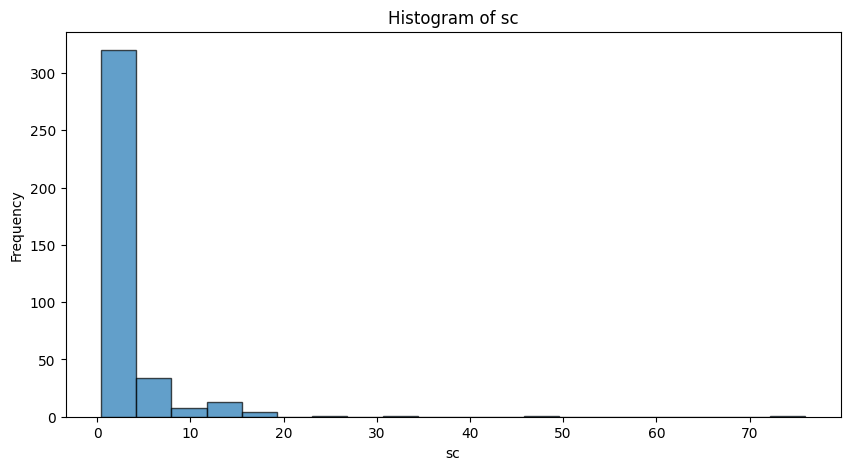

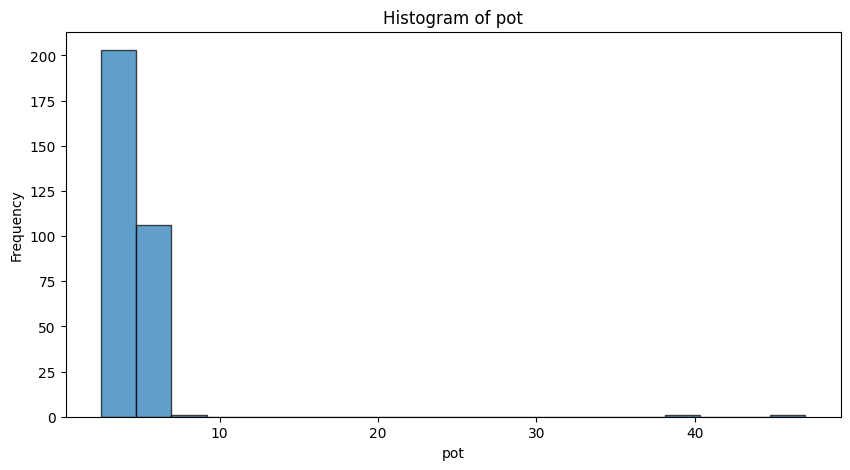

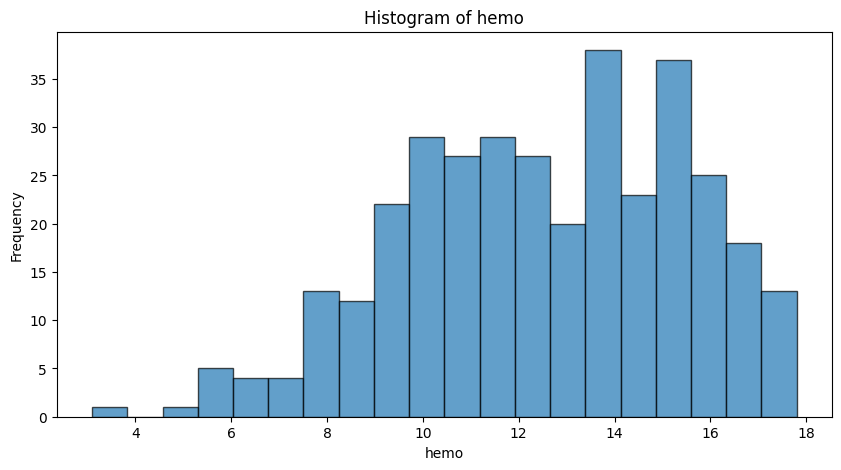

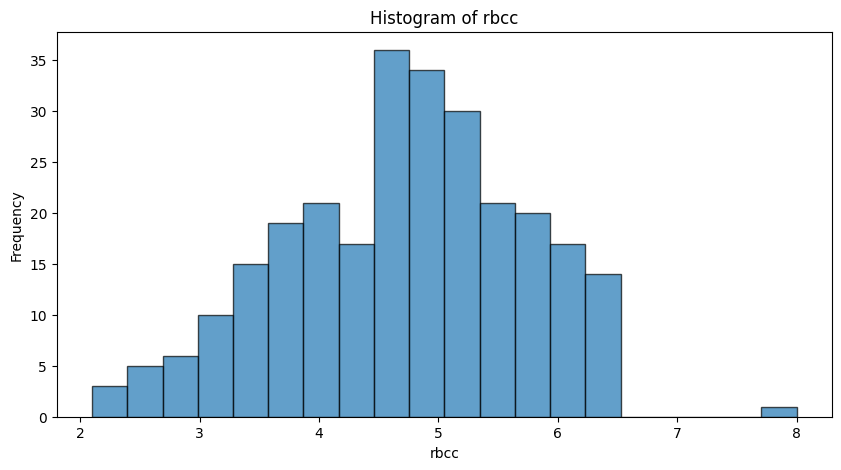

In [76]:
for variable in continuous_variables:
    plt.figure(figsize=(10, 5))
    plt.hist(X[variable].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.show()

In [77]:
integer_summary = X[integer_variables].describe()
categorical_summary = X[categorical_variables].describe()
print(integer_summary)
print(categorical_summary)

              age          bp         bgr          bu         sod         pcv  \
count  391.000000  388.000000  356.000000  381.000000  313.000000  329.000000   
mean    51.483376   76.469072  148.036517   57.425722  137.528754   38.884498   
std     17.169714   13.683637   79.281714   50.503006   10.408752    8.990105   
min      2.000000   50.000000   22.000000    1.500000    4.500000    9.000000   
25%     42.000000   70.000000   99.000000   27.000000  135.000000   32.000000   
50%     55.000000   80.000000  121.000000   42.000000  138.000000   40.000000   
75%     64.500000   80.000000  163.000000   66.000000  142.000000   45.000000   
max     90.000000  180.000000  490.000000  391.000000  163.000000   54.000000   

               wbcc  
count    294.000000  
mean    8406.122449  
std     2944.474190  
min     2200.000000  
25%     6500.000000  
50%     8000.000000  
75%     9800.000000  
max    26400.000000  
               sg          al          su
count  353.000000  354.000000 

Here is our main findings:
- There are 24 explanatory variables in the original dataset, among these variables, there are 11 quantative variables. And 13 categorical variables, including binary categorical variables and multi-level factors.

- There are 400 observations in the dataset.

- Among 4 continuous variables, there are two variables' distribution is right-skewed distribution, which are 'serum creatinine' and 'potassium'. And for 'hemoglobin' and 'red blood cell count', their distribution is approximately follow normal distribution.

- Among 7 integers variables, every one of them has missing values, which we will deal with in the following steps. Among them, we can see the maximum and minimum values of each integer variable. For example, for age, the maximum age in the sample is 90 years old. But for quantitative variables, the biggest problem is that they are on different scales. So we may need to standardize first. 

- For categorical variables we should use some dummy variable coding methods to transform the data. For example, effect dummy coding, cell means dummy coding are all feasible methods.

# Step 3 Handling Missing Value

We will replace missing values with the mean and mode for quanatitaive and categorical variables respectively.

In [78]:
# Fill missing values for quantitative variables with their median values
for column in quantitative_variables:
    X.fillna({column: X[column].median()}, inplace=True)

# Fill missing values for categorical variables with their mode
for column in cate_variables:
    if pd.isnull(X[column]).any():
        mode_value = X[column].mode()[0]
        X.fillna({column:mode_value}, inplace=True)

/var/folders/sf/sjjggql90hd6d9rhx8t3rlpc0000gn/T/ipykernel_93580/2352133434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna({column: X[column].median()}, inplace=True)
/var/folders/sf/sjjggql90hd6d9rhx8t3rlpc0000gn/T/ipykernel_93580/2352133434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna({column: X[column].median()}, inplace=True)
/var/folders/sf/sjjggql90hd6d9rhx8t3rlpc0000gn/T/ipykernel_93580/2352133434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

# Step 4 Variable Transformation

Just like what we discuss before, we will apply MinMaxScaler nomalization for the quantative variables and dummy coding for the categorical variables.

In [79]:
# Fit the scaler to data and transform
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X[quantitative_variables])
# Convert the array back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=quantitative_variables)
X.update(X_scaled)
# Create dummy variables for binary variables
X = pd.get_dummies(X, columns=binary_variables, drop_first=True)

# Step 5 Feature Selection
For feature selection, we used the simple statistics to select features that have the strongest relationship with the output variable. 
- We used the 'SelectKBest' class from the 'scikit-learn', which selects features based on the top K scores from a chi-squared test. 

- Also, we try to removing features with low variance first. 

In [80]:
dummy_variables = ['rbc_normal', 'pc_normal', 'pcc_present',
       'ba_present', 'htn_yes', 'dm_no', 'dm_yes', 'cad_yes', 'appet_poor',
       'pe_yes', 'ane_yes']
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_filtered_binary = selector.fit_transform(X[dummy_variables])
retained_binary_columns = pd.Index(dummy_variables)[selector.get_support()]
X_filtered_binary = pd.DataFrame(X_filtered_binary, columns=retained_binary_columns, index=X.index)

# Drop original binary columns from X and concatenate the filtered binary data
X_final = X.drop(columns=dummy_variables)
X_final = pd.concat([X_final, X_filtered_binary], axis=1)

print("Modified DataFrame with low variance binary variables removed:")
print(X_final.head())

Modified DataFrame with low variance binary variables removed:
        age        bp     sg   al   su       bgr        bu        sc  \
0  0.522727  0.230769  1.020  1.0  0.0  0.211538  0.088575  0.010582   
1  0.056818  0.000000  1.020  4.0  0.0  0.211538  0.042362  0.005291   
2  0.681818  0.230769  1.010  2.0  3.0  0.856838  0.132221  0.018519   
3  0.522727  0.153846  1.005  4.0  0.0  0.202991  0.139923  0.044974   
4  0.556818  0.230769  1.010  2.0  0.0  0.179487  0.062901  0.013228   

        sod       pot      hemo       pcv      wbcc      rbcc  htn_yes  dm_no  \
0  0.842271  0.042697  0.836735  0.777778  0.231405  0.525424     True  False   
1  0.842271  0.042697  0.557823  0.644444  0.157025  0.457627    False   True   
2  0.842271  0.042697  0.442177  0.488889  0.219008  0.457627    False  False   
3  0.671924  0.000000  0.551020  0.511111  0.185950  0.305085     True   True   
4  0.842271  0.042697  0.578231  0.577778  0.210744  0.423729    False   True   

   dm_yes  appet_

In [81]:
select_k_best = SelectKBest(score_func=chi2, k=10)
X_selected = select_k_best.fit_transform(X_final, y)
selected_features = X_final.columns[select_k_best.get_support()]
print("Selected features:", selected_features)
X_selected_df = X_final[selected_features]

Selected features: Index(['al', 'su', 'bu', 'hemo', 'pcv', 'rbcc', 'htn_yes', 'dm_no', 'dm_yes',
       'appet_poor'],
      dtype='object')


In [82]:
X_selected_df.head(5)

,al,su,bu,hemo,pcv,rbcc,htn_yes,dm_no,dm_yes,appet_poor
0,1.0,0.0,0.088575,0.836735,0.777778,0.525424,True,False,True,False
1,4.0,0.0,0.042362,0.557823,0.644444,0.457627,False,True,False,False
2,2.0,3.0,0.132221,0.442177,0.488889,0.457627,False,False,True,True
3,4.0,0.0,0.139923,0.551020,0.511111,0.305085,True,True,False,True
4,2.0,0.0,0.062901,0.578231,0.577778,0.423729,False,True,False,False


# Step 6 Outlier Analysis

Normally, we will use Cook's Distance or Leverage to identify influential observations. But we have to fit a full model first, so for this stage we won't address the outlier analysis.

# Step 7 Sub-group Analysis

We used t-distributed Stochastic Neighbor Embedding to converts affinities of data points to probabilities.

/Users/timzhang/Desktop/STATS3DA3/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


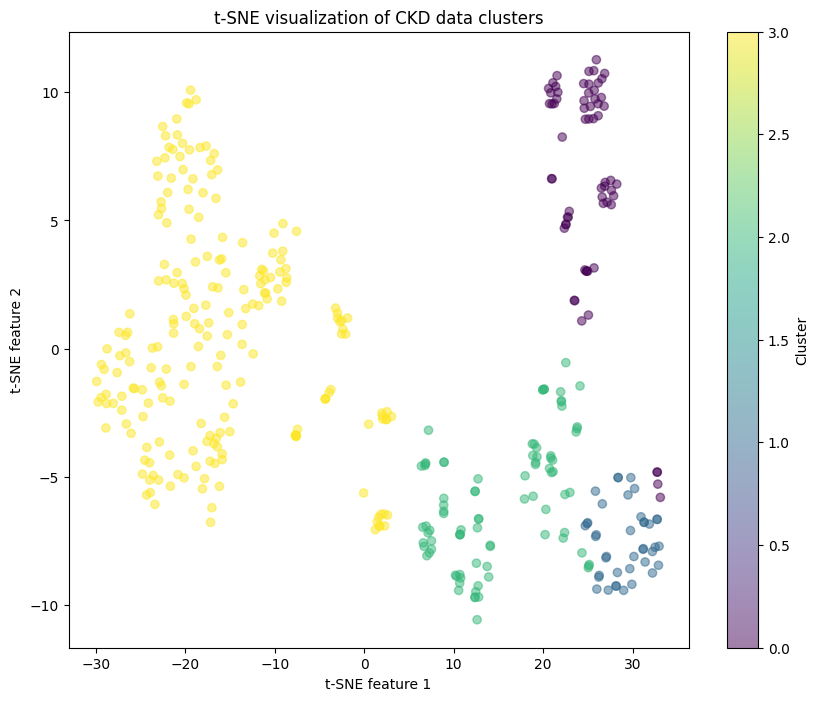

In [83]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_selected_df)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_selected_df)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('t-SNE visualization of CKD data clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

# Step 8 Data Spliting

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.30, random_state=1)


# Step 9 Classifier Choices

KNN is relatively simple to implement and understand since it is based on the principle of similarity, where instances are classified based on the majority class of their nearest neighbors in the feature space. KNN tends to create localized decision boundaries, which can help capture complex patterns in chronic kidney disease data.

In [85]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [86]:
KNN = KNeighborsClassifier(n_neighbors = 30)
KNN.fit(X_train, y_train)

KNNAccuracy = accuracy_score(y_test, KNN.predict(X_test))

print(f"Training Accuracy of KNN :{accuracy_score(y_train, KNN.predict(X_train))}")
print(f"Test Accuracy of KNN :{KNNAccuracy} ")
print(f"Confusion Matrix :\n {confusion_matrix(y_test, KNN.predict(X_test))}")
print(f"Classification Report :\n{classification_report(y_test, KNN.predict(X_test))}")

Training Accuracy of KNN :0.9428571428571428
Test Accuracy of KNN :0.9166666666666666 
Confusion Matrix :
 [[60 10]
 [ 0 50]]
Classification Report :
              precision    recall  f1-score   support

         ckd       1.00      0.86      0.92        70
      notckd       0.83      1.00      0.91        50

    accuracy                           0.92       120
   macro avg       0.92      0.93      0.92       120
weighted avg       0.93      0.92      0.92       120



/Users/timzhang/Desktop/STATS3DA3/.venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Decision trees provide a transparent and interpretable structure for understanding the factors most significantly contributing to the prediction of chronic kidney disease. Also, decision tree algorithms can handle datasets with many features and instances, making them suitable for the Chronic Kidney Disease dataset.

In [90]:
from sklearn.tree import DecisionTreeClassifier

In [91]:
DecisionTree = DecisionTreeClassifier(max_depth=20, max_features = 2)
DecisionTree.fit(X_train, y_train)

DTAccuracy = accuracy_score(y_test, DecisionTree.predict(X_test))

print(f"Training Accuracy of Decision Tree: {accuracy_score(y_train, DecisionTree.predict(X_train))}")
print(f"Test Accuracy of Decision Tree: {DTAccuracy} \n")
print(f"Confusion Matrix : \n{confusion_matrix(y_test, DecisionTree.predict(X_test))}\n")
print(f"Classification Report : \n {classification_report(y_test, DecisionTree.predict(X_test))}")


Training Accuracy of Decision Tree: 1.0
Test Accuracy of Decision Tree: 0.95 

Confusion Matrix : 
[[64  6]
 [ 0 50]]

Classification Report : 
               precision    recall  f1-score   support

         ckd       1.00      0.91      0.96        70
      notckd       0.89      1.00      0.94        50

    accuracy                           0.95       120
   macro avg       0.95      0.96      0.95       120
weighted avg       0.96      0.95      0.95       120



# Step 10 Performance Metrics

The first metric for comparing performance is the accuracy score since it provides the simplest measure of the classifier's overall performance.

Another metric for comparing performance is the value of the F1-score from the classification report. It is a robust metric for evaluating and comparing classifiers.

# Step 11 Feature Selection/Extraction

In [92]:
from sklearn.model_selection import GridSearchCV
ParameterGrid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 7, 10],
    'splitter' : ['best', 'random'],
    'min_samples_leaf' : [1, 2, 3, 5, 7],
    'min_samples_split' : [1.0, 2, 3, 5, 7],
    'max_features' : [None, 'sqrt', 'log2']
}

DecisionTreeGridSearching = GridSearchCV(DecisionTree, ParameterGrid, cv = 5 , n_jobs = -1, verbose = 1)
DecisionTreeGridSearching.fit(X_train, y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


/Users/timzhang/Desktop/STATS3DA3/.venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=20, max_features=2),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 5, 7],
                         'min_samples_split': [1.0, 2, 3, 5, 7],
                         'splitter': ['best', 'random']},
             verbose=1)

In [93]:
print(DecisionTreeGridSearching.best_params_)
print(DecisionTreeGridSearching.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
0.9714285714285715


In [94]:
DecisionTree2 = DecisionTreeGridSearching.best_estimator_
DTAccuracy2 = accuracy_score(y_test, DecisionTree2.predict(X_test))

print(f"Training Accuracy of Decision Tree: {accuracy_score(y_train, DecisionTree2.predict(X_train))}")
print(f"Test Accuracy of Decision Tree: {DTAccuracy2} \n")
print(f"Confusion Matrix : \n{confusion_matrix(y_test, DecisionTree2.predict(X_test))}\n")
print(f"Classification Report : \n {classification_report(y_test, DecisionTree2.predict(X_test))}")

Training Accuracy of Decision Tree: 0.9678571428571429
Test Accuracy of Decision Tree: 0.9666666666666667 

Confusion Matrix : 
[[67  3]
 [ 1 49]]

Classification Report : 
               precision    recall  f1-score   support

         ckd       0.99      0.96      0.97        70
      notckd       0.94      0.98      0.96        50

    accuracy                           0.97       120
   macro avg       0.96      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



# Step 12 Classifier Comparison

In [95]:
print(f"Training Accuracy of KNN :{accuracy_score(y_train, KNN.predict(X_train))}")
print(f"Test Accuracy of KNN :{KNNAccuracy} ")
print(f"Training Accuracy of Decision Tree: {accuracy_score(y_train, DecisionTree2.predict(X_train))}")
print(f"Test Accuracy of Decision Tree: {DTAccuracy2} \n")

Training Accuracy of KNN :0.9428571428571428
Test Accuracy of KNN :0.9166666666666666 
Training Accuracy of Decision Tree: 0.9678571428571429
Test Accuracy of Decision Tree: 0.9666666666666667 



In [96]:
print(f"KNN Confusion Matrix :\n {confusion_matrix(y_test, KNN.predict(X_test))}")
print(f"DT Confusion Matrix : \n{confusion_matrix(y_test, DecisionTree2.predict(X_test))}\n")
print(f"KNN Classification Report :\n{classification_report(y_test, KNN.predict(X_test))}")
print(f"DT Classification Report : \n {classification_report(y_test, DecisionTree2.predict(X_test))}")

KNN Confusion Matrix :
 [[60 10]
 [ 0 50]]
DT Confusion Matrix : 
[[67  3]
 [ 1 49]]

KNN Classification Report :
              precision    recall  f1-score   support

         ckd       1.00      0.86      0.92        70
      notckd       0.83      1.00      0.91        50

    accuracy                           0.92       120
   macro avg       0.92      0.93      0.92       120
weighted avg       0.93      0.92      0.92       120

DT Classification Report : 
               precision    recall  f1-score   support

         ckd       0.99      0.96      0.97        70
      notckd       0.94      0.98      0.96        50

    accuracy                           0.97       120
   macro avg       0.96      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



Comparing the two Classification Reports, we can see that the Decision Tree classifier has higher accuracy and F1-score values. From this statement, we can say that the Decision Tree classifier is better than the KNN classifier. However, the differences are between 0.01 and 0.02 which is very small.

# Step 13 Interpretable Classifier Insight

In [127]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import numpy as np
import pandas as pd

In [130]:
X_selected = X_final.iloc[:, 0:14]
X_selected


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
0,0.522727,0.230769,1.020,1.0,0.0,0.211538,0.088575,0.010582,0.842271,0.042697,0.836735,0.777778,0.231405,0.525424
1,0.056818,0.000000,1.020,4.0,0.0,0.211538,0.042362,0.005291,0.842271,0.042697,0.557823,0.644444,0.157025,0.457627
2,0.681818,0.230769,1.010,2.0,3.0,0.856838,0.132221,0.018519,0.842271,0.042697,0.442177,0.488889,0.219008,0.457627
3,0.522727,0.153846,1.005,4.0,0.0,0.202991,0.139923,0.044974,0.671924,0.000000,0.551020,0.511111,0.185950,0.305085
4,0.556818,0.230769,1.010,2.0,0.0,0.179487,0.062901,0.013228,0.842271,0.042697,0.578231,0.577778,0.210744,0.423729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.602273,0.230769,1.020,0.0,0.0,0.252137,0.121951,0.001323,0.917981,0.053933,0.857143,0.844444,0.185950,0.474576
396,0.454545,0.153846,1.025,0.0,0.0,0.113248,0.075738,0.010582,0.861199,0.022472,0.911565,1.000000,0.231405,0.694915
397,0.113636,0.230769,1.020,0.0,0.0,0.166667,0.062901,0.002646,0.835962,0.042697,0.863946,0.888889,0.181818,0.559322
398,0.170455,0.076923,1.025,0.0,0.0,0.196581,0.124519,0.007937,0.823344,0.053933,0.755102,0.933333,0.206612,0.644068


In [131]:
y

,class
0,ckd
1,ckd
2,ckd
3,ckd
4,ckd
...,...
395,notckd
396,notckd
397,notckd
398,notckd


In [137]:
final=pd.concat([X_selected, y], axis=1)
final

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
0,0.522727,0.230769,1.020,1.0,0.0,0.211538,0.088575,0.010582,0.842271,0.042697,0.836735,0.777778,0.231405,0.525424,ckd
1,0.056818,0.000000,1.020,4.0,0.0,0.211538,0.042362,0.005291,0.842271,0.042697,0.557823,0.644444,0.157025,0.457627,ckd
2,0.681818,0.230769,1.010,2.0,3.0,0.856838,0.132221,0.018519,0.842271,0.042697,0.442177,0.488889,0.219008,0.457627,ckd
3,0.522727,0.153846,1.005,4.0,0.0,0.202991,0.139923,0.044974,0.671924,0.000000,0.551020,0.511111,0.185950,0.305085,ckd
4,0.556818,0.230769,1.010,2.0,0.0,0.179487,0.062901,0.013228,0.842271,0.042697,0.578231,0.577778,0.210744,0.423729,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.602273,0.230769,1.020,0.0,0.0,0.252137,0.121951,0.001323,0.917981,0.053933,0.857143,0.844444,0.185950,0.474576,notckd
396,0.454545,0.153846,1.025,0.0,0.0,0.113248,0.075738,0.010582,0.861199,0.022472,0.911565,1.000000,0.231405,0.694915,notckd
397,0.113636,0.230769,1.020,0.0,0.0,0.166667,0.062901,0.002646,0.835962,0.042697,0.863946,0.888889,0.181818,0.559322,notckd
398,0.170455,0.076923,1.025,0.0,0.0,0.196581,0.124519,0.007937,0.823344,0.053933,0.755102,0.933333,0.206612,0.644068,notckd


In [139]:
predictor_vars = ' + '.join(
    final.drop('class', axis = 1).columns
    )  
formula = f'class ~ {predictor_vars}'
formula

'class ~ age + bp + sg + al + su + bgr + bu + sc + sod + pot + hemo + pcv + wbcc + rbcc'

In [140]:
y, X = dmatrices(
    formula,
    data = final,
    return_type = 'dataframe'
)

SyntaxError: invalid syntax (<unknown>, line 1)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.30, random_state=1)

In [143]:
res_all = sm.OLS(y_train, X_train).fit()
res_all.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

By using Multiple Linear Regression, I found that we cannot use all the predictor variables, the types of some predictor variables do not fit the model. Also, the type of the response variable does not fit the model. We still need to use Decision Tree classifier and the KNN classifier.

# Step 15 Team Contributions

- 1-8:Zixin Cai 
- 9-11:Jean-Jacques Wang
- 12-16:Zhitao Zhang


# Step 16 Link

https://github.com/TimZhang370/A6.git